<a href="https://colab.research.google.com/github/Umesh94kr/COCO_dataset_image_detection/blob/main/Image_detection_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2023-12-14 06:52:29--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.59.137, 52.216.204.195, 16.182.96.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.59.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  15.9MB/s    in 20m 3s  

2023-12-14 07:12:32 (15.3 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2023-12-14 07:12:32--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.254, 52.216.40.209, 16.182.33.129, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.254|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[============

In [5]:
from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
  try:
    with ZipFile(extract_path + ".zip") as zfile:
      zfile.extractall(extract_path)

    # remove zip file
    zfileTOremove = f'{extract_path}' + '.zip'
    if os.path.isfile(zfileTOremove):
      os.remove(zfileTOremove)
    else:
      print("Error File not Found")

  except BadZipFile as e:
    print("Error:", e)

extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)


In [6]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}

        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license

    def get_imgIds(self):
        return list(self.im_dict.keys())

    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [7]:
coco_annotations_file="/content/coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="/content/coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)


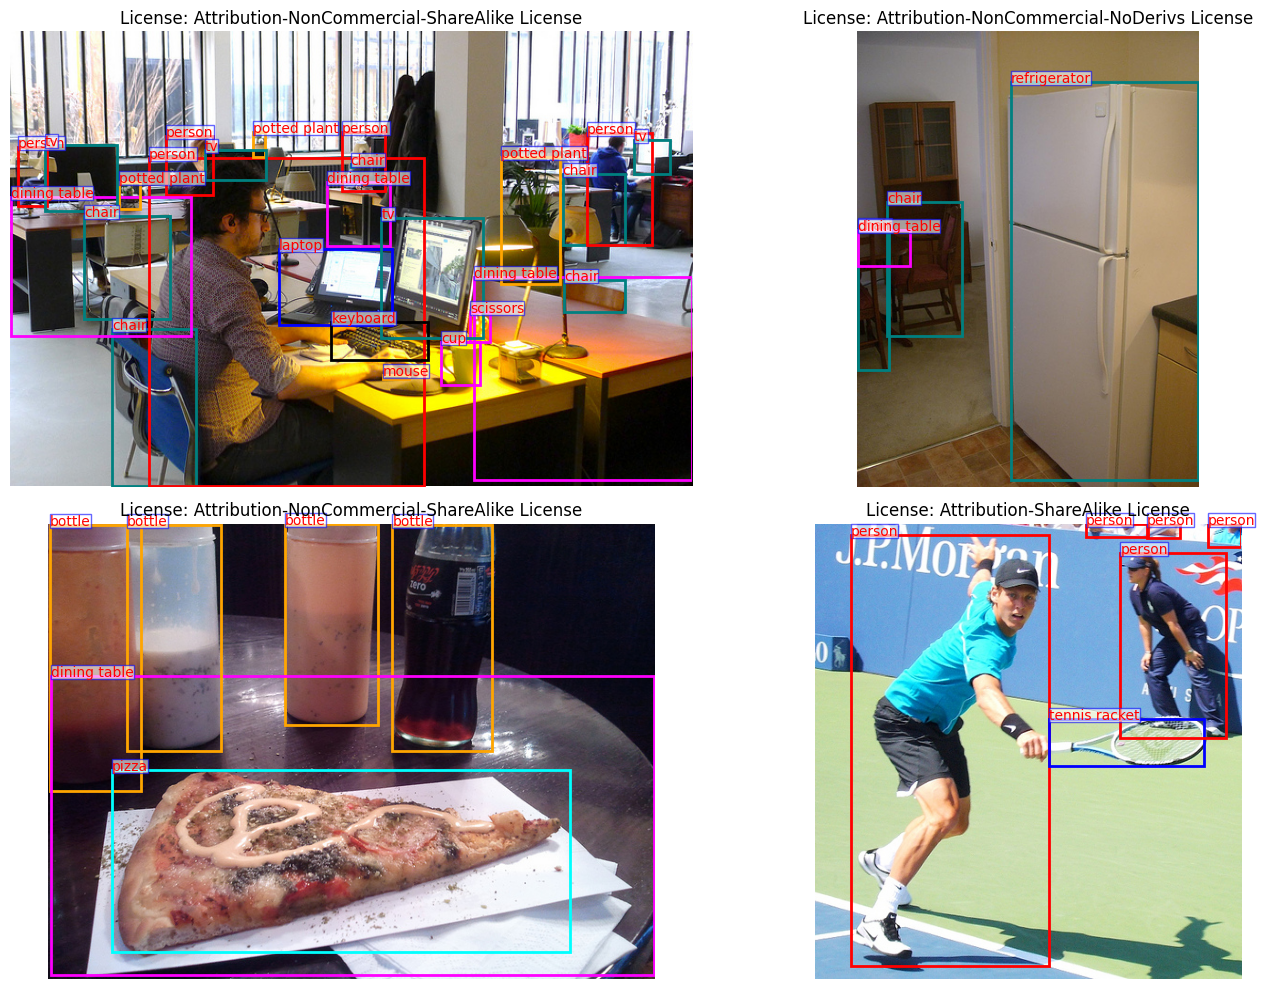

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10

num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]

img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]

ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()

for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')

        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)


    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")

plt.tight_layout()
plt.show()